In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.nn import Parameter
import sys
sys.path.append('../')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.0 cuda: True


# Parameters

In [3]:
# model parameters
NUM_PIXELS = 784
NUM_HIDDEN = 256
NUM_DIGITS = 10
NUM_LATENT = 10   

# training parameters
NUM_SAMPLES = 8 
NUM_BATCH = 128
NUM_EPOCHS = 200
LEARNING_RATE = 1e-3
BETA1 = 0.90
EPS = 1e-9
CUDA = torch.cuda.is_available()

# path parameters
MODEL_NAME = 'mnist-%02ddim' % NUM_LATENT
DATA_PATH = '../data'
WEIGHTS_PATH = '../weights'
RESTORE = False

# Encoder Model

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_latent=NUM_LATENT,
                       num_batch=NUM_BATCH):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential( 
                            nn.Linear(num_pixels, num_hidden),
                            nn.ReLU())
        self.z_mean = nn.Linear(num_hidden, num_latent)
        self.z_log_std = nn.Linear(num_hidden, num_latent)
    
    @expand_inputs
    def forward(self, images, labels=None, num_samples=None):
        q = probtorch.Trace()
        hiddens = self.enc_hidden(images)
        q.normal(self.z_mean(hiddens),
                 self.z_log_std(hiddens).exp(),
                 name='z')
        return q

# Decoder Model

In [5]:
class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_latent=NUM_LATENT):
        super(self.__class__, self).__init__()
        self.z_mean = torch.zeros(num_latent)
        self.z_std = torch.ones(num_latent)
        self.dec_image = nn.Sequential(
                           nn.Linear(num_latent, num_hidden),
                           nn.ReLU(),
                           nn.Linear(num_hidden, num_pixels),
                           nn.Sigmoid())

    def forward(self, images, q=None, num_samples=None):
        p = probtorch.Trace()
        z = p.normal(self.z_mean, 
                     self.z_std,
                     value=q['z'],
                     name='z')
        images_mean = self.dec_image(z)
        p.loss(lambda x_hat, x: -(torch.log(x_hat + EPS) * x + 
                                  torch.log(1 - x_hat + EPS) * (1-x)).sum(-1),
               images_mean, images, name='x')
        return p

# Loss

In [6]:
def elbo(q, p, alpha=0.1):
    if NUM_SAMPLES is None:
        return probtorch.objectives.montecarlo.elbo(q, p, sample_dim=None, batch_dim=0, alpha=alpha)
    else:
        return probtorch.objectives.montecarlo.elbo(q, p, sample_dim=0, batch_dim=1, alpha=alpha)

# Data

In [7]:
from torchvision import datasets, transforms
import os 

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

train_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=True, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 
test_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=False, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 

# Training and Testing

In [8]:
def cuda_tensors(obj): 
    for attr in dir(obj):
        value = getattr(obj, attr)
        if isinstance(value, torch.Tensor):
            setattr(obj, attr, value.cuda())

enc = Encoder()
dec = Decoder()
if CUDA:
    enc.cuda()
    dec.cuda()
    cuda_tensors(enc)
    cuda_tensors(dec)

optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                              lr=LEARNING_RATE,
                              betas=(BETA1, 0.999))

In [9]:
def train(data, enc, dec, optimizer):
    epoch_elbo = 0.0
    enc.train()
    dec.train()
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            optimizer.zero_grad()
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            loss = -elbo(q, p)
            loss.backward()
            optimizer.step()
            if CUDA:
                loss = loss.cpu()
            epoch_elbo -= float(loss.item())
    return epoch_elbo / N

def test(data, enc, dec):
    enc.eval()
    dec.eval()
    epoch_elbo = 0.0
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            images = images.view(-1, NUM_PIXELS)
            if CUDA:
                images = images.cuda()
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            batch_elbo = elbo(q, p)
            if CUDA:
                batch_elbo = batch_elbo.cpu()
            epoch_elbo += float(batch_elbo.item())
    return epoch_elbo / N

In [10]:
import time
from random import random
if not RESTORE:
    mask = {}
    for e in range(NUM_EPOCHS):
        train_start = time.time()
        train_elbo = train(train_data, enc, dec, optimizer)
        train_end = time.time()
        test_start = time.time()
        test_elbo = test(test_data, enc, dec)
        test_end = time.time()
        print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e (%ds)' % (
                e, train_elbo, train_end - train_start, 
                test_elbo, test_end - test_start))

    if not os.path.isdir(WEIGHTS_PATH):
        os.mkdir(WEIGHTS_PATH)
    torch.save(enc.state_dict(),
               '%s/%s-%s-%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__))
    torch.save(dec.state_dict(),
               '%s/%s-%s-%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__))

[Epoch 0] Train: ELBO -1.3498e+00 (3s) Test: ELBO -1.0316e+00 (0s)
[Epoch 1] Train: ELBO -9.9317e-01 (3s) Test: ELBO -9.5292e-01 (0s)
[Epoch 2] Train: ELBO -9.4539e-01 (3s) Test: ELBO -9.2314e-01 (0s)
[Epoch 3] Train: ELBO -9.2279e-01 (3s) Test: ELBO -9.0601e-01 (0s)
[Epoch 4] Train: ELBO -9.0854e-01 (3s) Test: ELBO -8.9529e-01 (0s)
[Epoch 5] Train: ELBO -8.9850e-01 (3s) Test: ELBO -8.8825e-01 (0s)
[Epoch 6] Train: ELBO -8.9066e-01 (3s) Test: ELBO -8.8083e-01 (0s)
[Epoch 7] Train: ELBO -8.8449e-01 (3s) Test: ELBO -8.7669e-01 (0s)
[Epoch 8] Train: ELBO -8.7961e-01 (3s) Test: ELBO -8.7176e-01 (0s)
[Epoch 9] Train: ELBO -8.7532e-01 (3s) Test: ELBO -8.6877e-01 (0s)
[Epoch 10] Train: ELBO -8.7151e-01 (3s) Test: ELBO -8.6501e-01 (0s)
[Epoch 11] Train: ELBO -8.6828e-01 (3s) Test: ELBO -8.6336e-01 (0s)
[Epoch 12] Train: ELBO -8.6552e-01 (3s) Test: ELBO -8.6143e-01 (0s)
[Epoch 13] Train: ELBO -8.6301e-01 (3s) Test: ELBO -8.5844e-01 (0s)
[Epoch 14] Train: ELBO -8.6053e-01 (3s) Test: ELBO -8.5569

[Epoch 121] Train: ELBO -8.1505e-01 (3s) Test: ELBO -8.2455e-01 (0s)
[Epoch 122] Train: ELBO -8.1490e-01 (3s) Test: ELBO -8.2411e-01 (0s)
[Epoch 123] Train: ELBO -8.1498e-01 (3s) Test: ELBO -8.2437e-01 (0s)
[Epoch 124] Train: ELBO -8.1488e-01 (3s) Test: ELBO -8.2340e-01 (0s)
[Epoch 125] Train: ELBO -8.1470e-01 (3s) Test: ELBO -8.2439e-01 (0s)
[Epoch 126] Train: ELBO -8.1484e-01 (3s) Test: ELBO -8.2379e-01 (0s)
[Epoch 127] Train: ELBO -8.1434e-01 (3s) Test: ELBO -8.2422e-01 (0s)
[Epoch 128] Train: ELBO -8.1434e-01 (3s) Test: ELBO -8.2346e-01 (0s)
[Epoch 129] Train: ELBO -8.1419e-01 (3s) Test: ELBO -8.2390e-01 (0s)
[Epoch 130] Train: ELBO -8.1424e-01 (3s) Test: ELBO -8.2425e-01 (0s)
[Epoch 131] Train: ELBO -8.1417e-01 (3s) Test: ELBO -8.2414e-01 (0s)
[Epoch 132] Train: ELBO -8.1400e-01 (3s) Test: ELBO -8.2422e-01 (0s)
[Epoch 133] Train: ELBO -8.1396e-01 (3s) Test: ELBO -8.2318e-01 (0s)
[Epoch 134] Train: ELBO -8.1379e-01 (3s) Test: ELBO -8.2339e-01 (0s)
[Epoch 135] Train: ELBO -8.1387e-0

In [11]:
if RESTORE:
    enc.load_state_dict(torch.load('%s/%s-%s-%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__)))
    dec.load_state_dict(torch.load('%s/%s-%s-%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__)))

# Visualize Embeddings

In [12]:
import numpy as np
ys = []
zs = []
for (x, y) in test_data:
    if len(x) == NUM_BATCH:
        images = x.view(-1, NUM_PIXELS)
        if CUDA:
            q = enc(images.cuda())
            z = q['z'].value.cpu().detach().numpy()
        else:
            q = enc(images)
            z = q['z'].value.data.detach().numpy()
        zs.append(z)
        ys.append(y.numpy())
ys = np.concatenate(ys,0)
zs = np.concatenate(zs,0)

In [13]:
# run TSNE when number of latent dims exceeds 2
if NUM_LATENT > 2:
    from sklearn.manifold import TSNE
    zs2 = TSNE().fit_transform(zs)
    zs2_mean = zs2.mean(0)
    zs2_std = zs2.std(0)
else:
    zs2 = zs

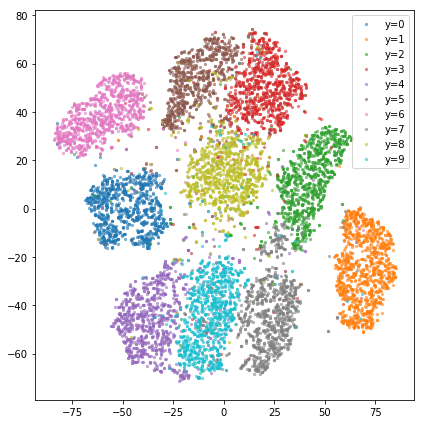

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# display a 2D plot of the digit classes in the latent space
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

colors = []
for k in range(10):
    m = (ys == k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%d' % k, alpha=0.5, s=5)
    colors.append(p.get_facecolor())
ax.legend()

fig.tight_layout()
#fig.savefig('images/%s-%02d-encodings.png' % (MODEL_NAME, NUM_STYLE), dpi=300)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

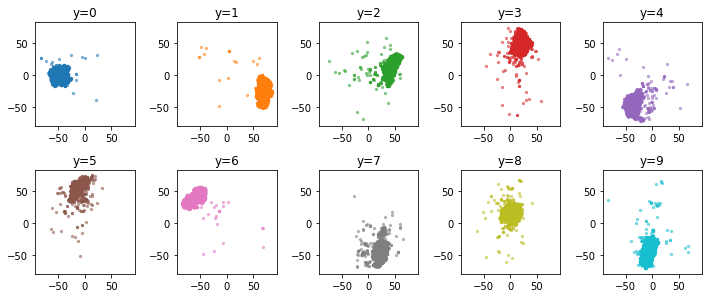

In [15]:
# display a 2D plot of the digit classes in the latent space
fig = plt.figure(figsize=(10,4.25))

for k in range(10):
    ax = plt.subplot(2,5,k+1)
    m = (ys == k)
    ax.scatter(zs2[m, 0], zs2[m, 1], alpha=0.5, s=5, c=colors[k])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title('y=%d' % k)

fig.tight_layout()

# Visualize Reconstructed Digits

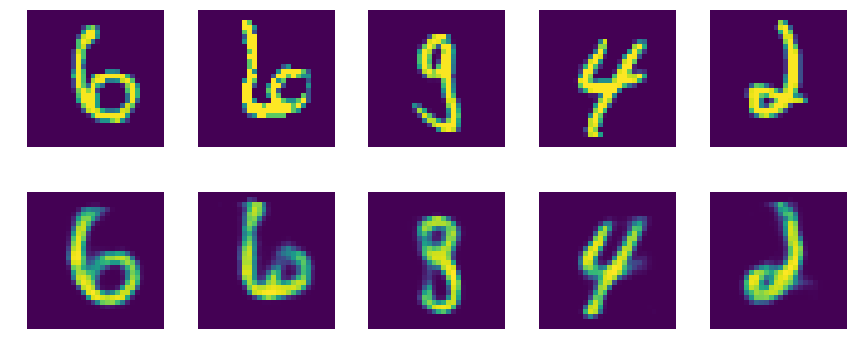

In [16]:
x,_ = next(iter(train_data))
x_var = x.view(-1, NUM_PIXELS)
if CUDA:
    q = enc(x_var.cuda())
    p = dec(x_var.cuda(), q)
    x_mean = p['x'].value.view(NUM_BATCH, 28, 28).data.cpu().numpy()
else:
    q = enc(x_var)
    p = dec(x_var, q)
    x_mean = p['x'].value.view(NUM_BATCH, 28, 28).data.numpy().squeeze()
    
fig = plt.figure(figsize=(12,5.25))
for k in range(5):
    ax = plt.subplot(2, 5, k+1)
    ax.imshow(x[k].squeeze())
    #ax.set_title("original")
    plt.axis("off")
    ax = plt.subplot(2, 5, k+6)
    ax.imshow(x_mean[k].squeeze())
    #ax.set_title("reconstructed")
    plt.axis("off")
    
fig.tight_layout()
#fig.savefig('images/%s-%02d-reconstructions-separate.png' % (MODEL_NAME, NUM_STYLE), dpi=300, facecolor=[0,0,0,0])